In [3]:
import networkx as nx # type: ignore
from tqdm import tqdm # type: ignore
import networkx as nx
import igraph as ig
from tqdm import tqdm
import matplotlib.pyplot as plt

%run toy_city_generation.ipynb
%run city_utilities.ipynb
%run real_city_generation.ipynb

%pip install osmnx matplotlib igraph

In [4]:
def get_valid_area(G, trip, tolerance=0.1):
    start_nodes = {n for n, data in G.nodes(data=True) if data.get("zone") == trip["start_zone_id"]}
    end_nodes = {n for n, data in G.nodes(data=True) if data.get("zone") == trip["end_zone_id"]}

    if not start_nodes or not end_nodes:
        return [], [], 0, 0

    valid_start_points = set()
    valid_end_points = set()

    with tqdm(total=len(start_nodes) * len(end_nodes), desc="Processing start and end nodes") as pbar:
        for s in start_nodes:
            for e in end_nodes:
                pbar.update(1)
            try:
                path_length = nx.shortest_path_length(G, source=s, target=e, weight="length")
                path_time = nx.shortest_path_length(G, source=s, target=e, weight="travel_time")

                length_ratio = abs(path_length - trip["distance"]) / trip["distance"]
                time_ratio = abs(path_time - trip["travel_time"]) / trip["travel_time"]

                if length_ratio < tolerance and time_ratio < tolerance:
                    valid_start_points.add(s)
                    valid_end_points.add(e)

            except nx.NetworkXNoPath:
                continue

    fraction_start = len(valid_start_points) / len(start_nodes) if start_nodes else 0
    fraction_end = len(valid_end_points) / len(end_nodes) if end_nodes else 0

    return list(valid_start_points), list(valid_end_points), fraction_start, fraction_end


In [ ]:
import networkx as nx
import random
from functools import lru_cache
from collections import deque

@lru_cache(None)
def get_cached_path(G, start, end):
    try:
        return nx.shortest_path(G, source=start, target=end, weight="travel_time")
    except nx.NetworkXNoPath:
        return None

def get_valid_area_fast(G, trip, tolerance=0.1, max_attempts=50, max_depth=5):
    start_nodes = {n for n, d in G.nodes(data=True) if d.get("zone") == trip["start_zone_id"]}
    end_nodes = {n for n, d in G.nodes(data=True) if d.get("zone") == trip["end_zone_id"]}

    if not start_nodes or not end_nodes:
        return [], [], 0, 0

    valid_start, valid_end = set(), set()
    attempts = 0

    while attempts < max_attempts:
        s, e = random.choice(tuple(start_nodes)), random.choice(tuple(end_nodes))
        path = get_cached_path(G, s, e)
        if path and is_valid_path(G, path, trip, tolerance):
            valid_start.add(s)
            valid_end.add(e)
            break
        attempts += 1

    if not valid_start:
        return [], [], 0, 0

    queue = deque([(0, path)])  # BFS queue with depth tracking
    visited = set()

    while queue:
        depth, path = queue.popleft()
        if depth >= max_depth:
            continue

        for new_path in generate_modified_paths(G, trip, path, tolerance):
            path_tuple = tuple(new_path)
            if path_tuple not in visited:
                visited.add(path_tuple)
                valid_start.add(new_path[0])
                valid_end.add(new_path[-1])
                queue.append((depth + 1, new_path))

    return list(valid_start), list(valid_end), len(valid_start) / len(start_nodes), len(valid_end) / len(end_nodes)

def generate_modified_paths(G, trip, path, tolerance):
    modified_paths = []
    neighbors = lambda node: G.neighbors(node)

    # Remove nodes from both ends
    if len(path) > 2:
        new_path_start_removed = path[1:]
        new_path_end_removed = path[:-1]
        if is_valid_path(G, new_path_start_removed, trip, tolerance):
            modified_paths.append(new_path_start_removed)
        if is_valid_path(G, new_path_end_removed, trip, tolerance):
            modified_paths.append(new_path_end_removed)

    # Add one neighbor to the start and end
    for idx, side in [(0, path[1]), (-1, path[-2])]:
        for neighbor in set(neighbors(path[idx])) - {side}:
            new_path = [neighbor] + path if idx == 0 else path + [neighbor]
            if is_valid_path(G, new_path, trip, tolerance):
                modified_paths.append(new_path)

    return modified_paths

def is_valid_path(G, path, trip, tolerance):
    """Check if path is valid based on length and travel time."""
    try:
        edges = [next(iter(G[u][v].values())) for u, v in zip(path[:-1], path[1:])]
    except (KeyError, StopIteration):
        return False

    total_length = sum(e["length"] for e in edges)
    total_time = sum(e["travel_time"] for e in edges)

    return (
        abs(total_length - trip["distance"]) / trip["distance"] < tolerance and
        abs(total_time - trip["travel_time"]) / trip["travel_time"] < tolerance
    )


Getting graph...
Graph loaded from 'nyc_roads.graphml'
Getting zones...
Assigning zones to nodes...
Fabricating trips...
Visualising real city...
Map saved as 'nyc_roads_map_with_zones.png'


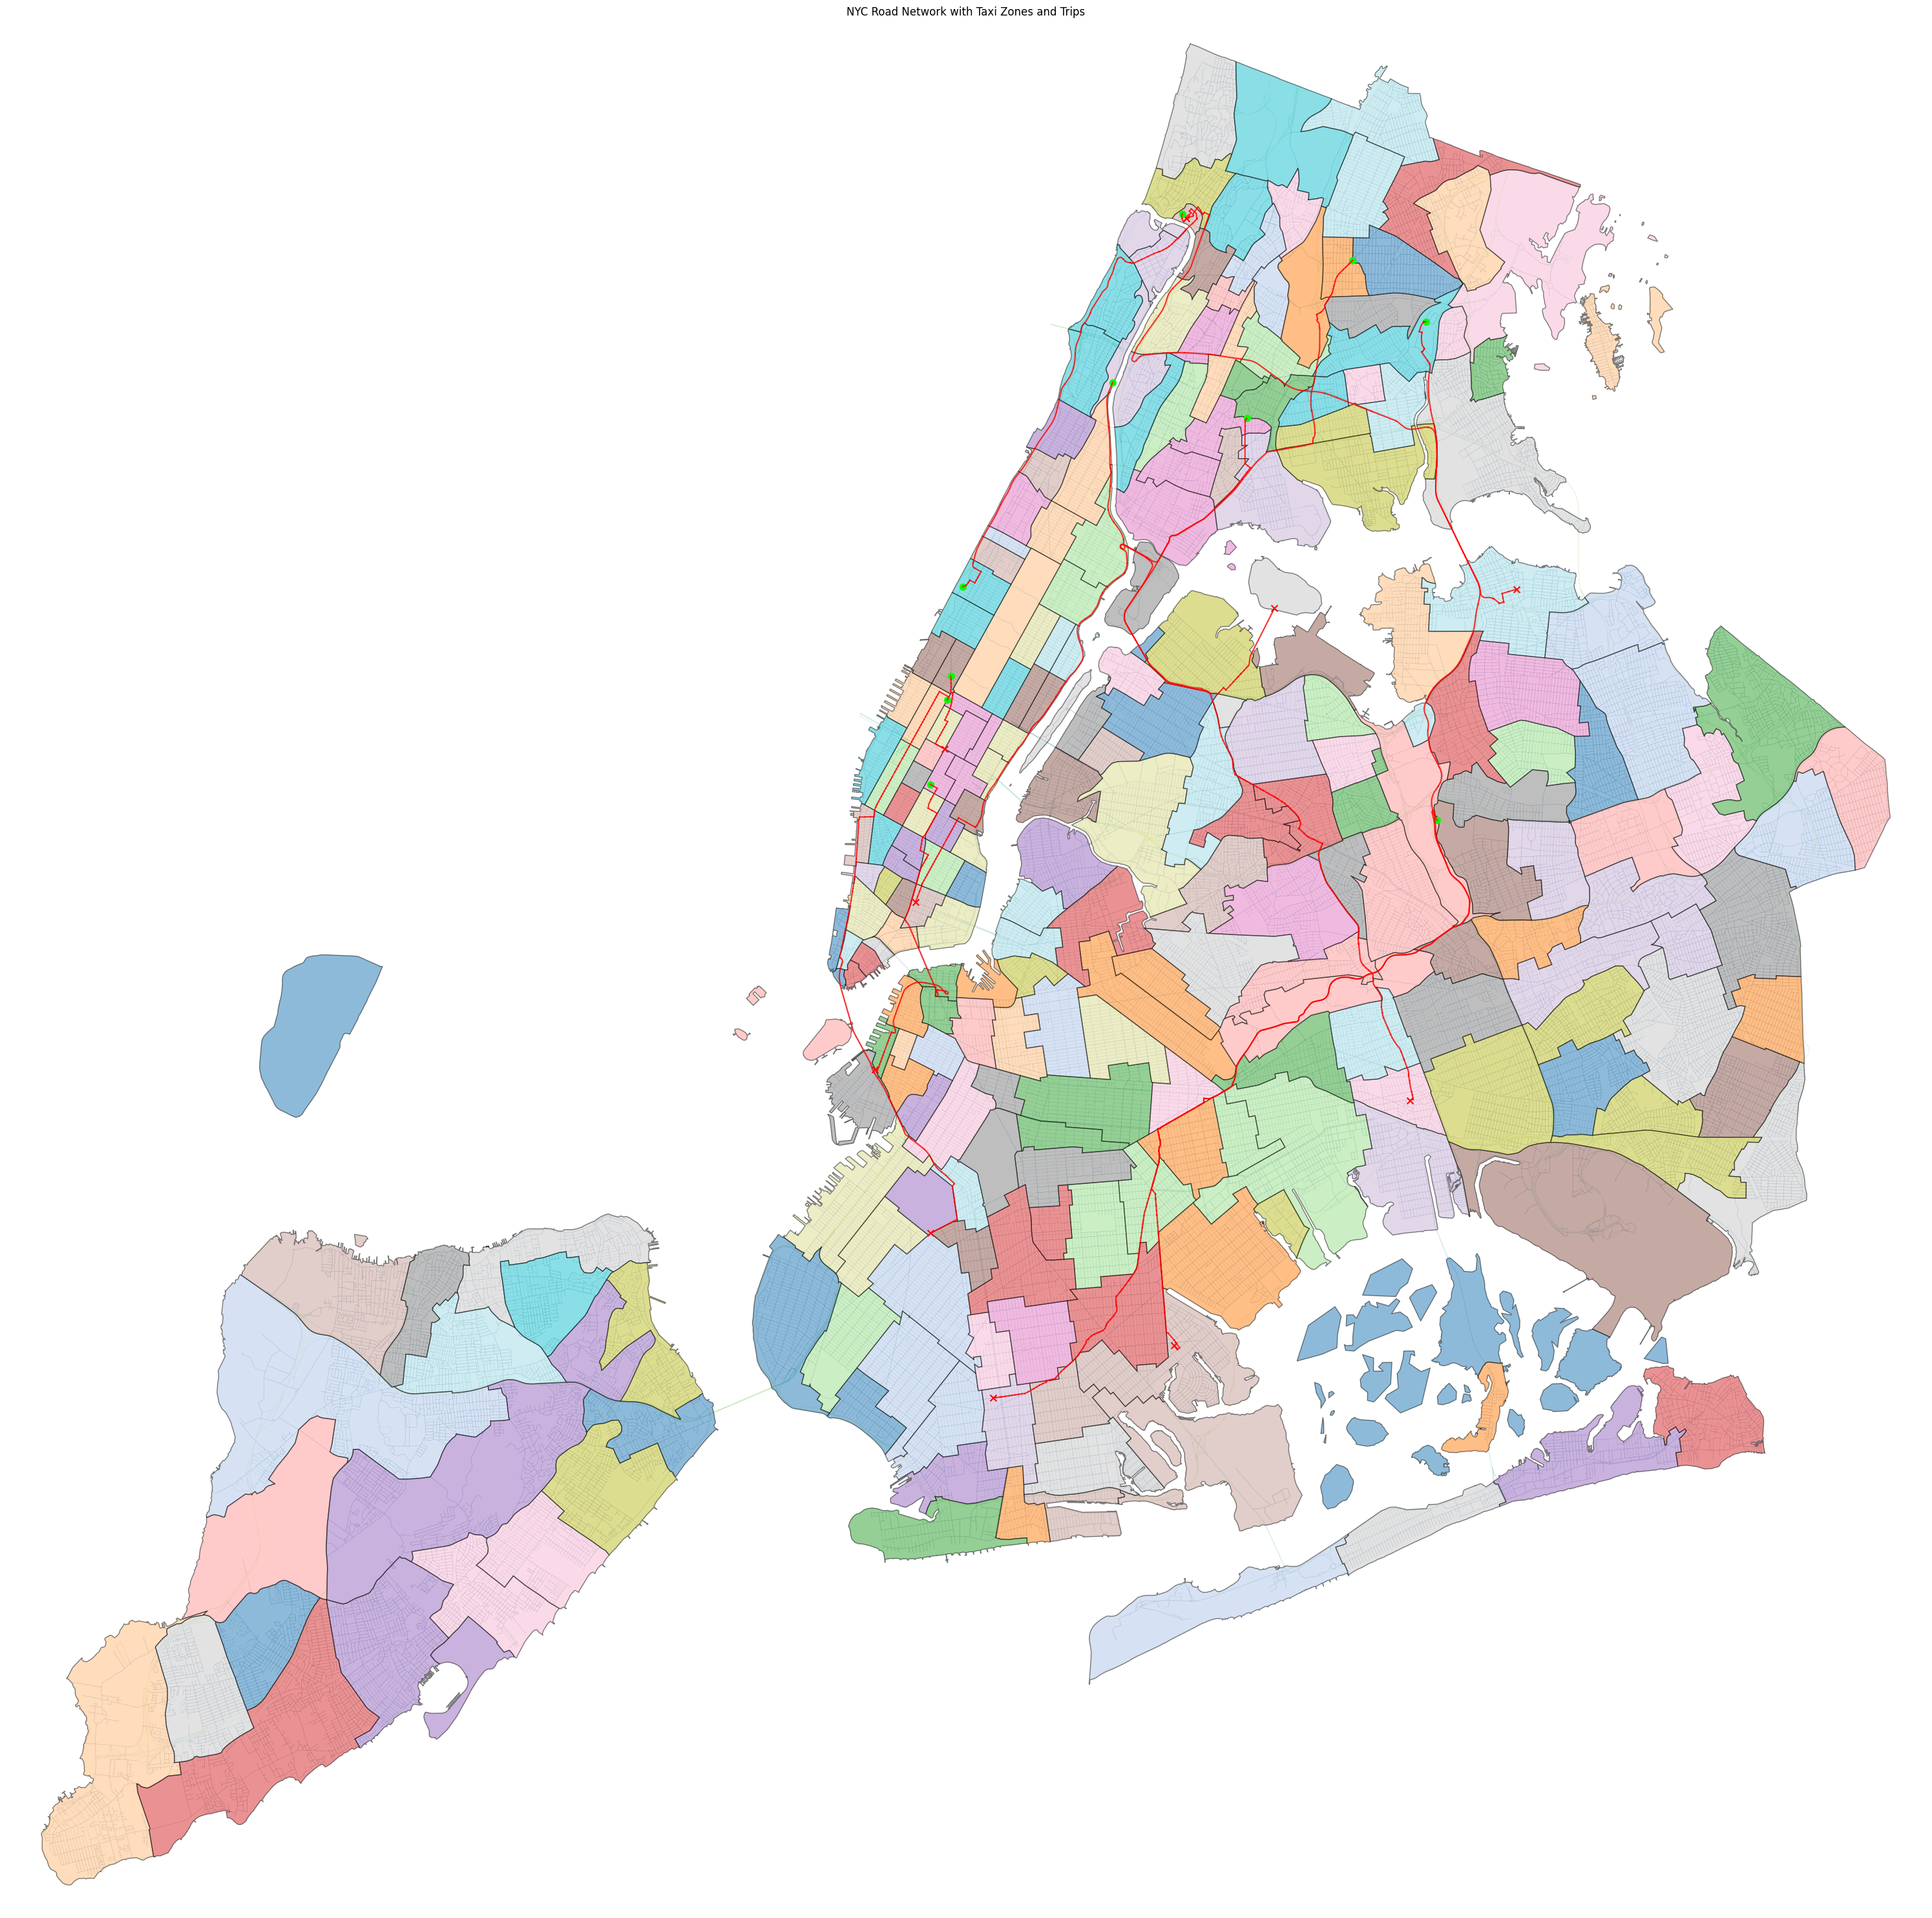

In [6]:
# Main function

USE_FAKE_CITY = False

if USE_FAKE_CITY:
    zones, street_graph, trips, width, height = generate_synthetic_city_data() # type: ignore
    visualise(street_graph, zones, width, height, trips=trips) # type: ignore
else:
    zones, street_graph, trips = generate_real_city_data() # type: ignore
    print("Visualising real city...")
    display_real_city(street_graph, zones, trips) # type: ignore

In [7]:
# IGraph might be faster?
CONVERT_TO_IGRAPH = False

if CONVERT_TO_IGRAPH:
    i_street_graph = ig.Graph(directed=True)
    print("Adding vertices...")

    node_id_map = {node: idx for idx, node in enumerate(street_graph.nodes())}

    i_street_graph.add_vertices(len(node_id_map))
    
    print("Adding edges...")
    edge_attributes = ['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'speed_kph', 'travel_time']
    for u, v, data in tqdm(street_graph.edges(data=True), desc="Adding edges"):
        i_street_graph.add_edge(node_id_map[u], node_id_map[v], **{attr: data.get(attr, None) for attr in edge_attributes})

    print("Adding attributes...")
    attributes = ['y', 'x', 'highway', 'ref', 'street_count', 'zone']
    for attr in attributes:
        i_street_graph.vs[attr] = [street_graph.nodes[node].get(attr, None) for node in street_graph.nodes()]

{'id': 0, 'start_zone_id': 3, 'start_zone_name': 'Allerton/Pelham Gardens', 'end_zone_id': 148, 'end_zone_name': 'Lower East Side', 'travel_time': 1375.5245863171963, 'distance': 21096.476513984526, 'start_node': 42730940, 'end_node': 42429754, 'start_coordinate': (-73.861542, 40.866154), 'end_coordinate': (-73.9929475, 40.7199105), 'route': [42730940, 42744533, 42745120, 12538085582, 42762606, 42746694, 42734598, 2856760698, 42745603, 2313404814, 42738425, 42769052, 2313404816, 2313404821, 42769585, 42769581, 42724404, 42744845, 4048271046, 42726810, 42732770, 3306795024, 471213641, 103028462, 596683859, 103049637, 103049647, 103049649, 60653847, 60653852, 42721930, 42737334, 42723865, 60653787, 566379402, 7477291296, 12101548681, 588113931, 471240719, 471240527, 100659881, 277481443, 6159356505, 6159356499, 277482762, 3786728557, 42433431, 42424133, 42427009, 42433490, 3631837584, 42433422, 42424145, 42438809, 42450634, 371188320, 406006393, 5426969134, 370924677, 5779545445, 3709128

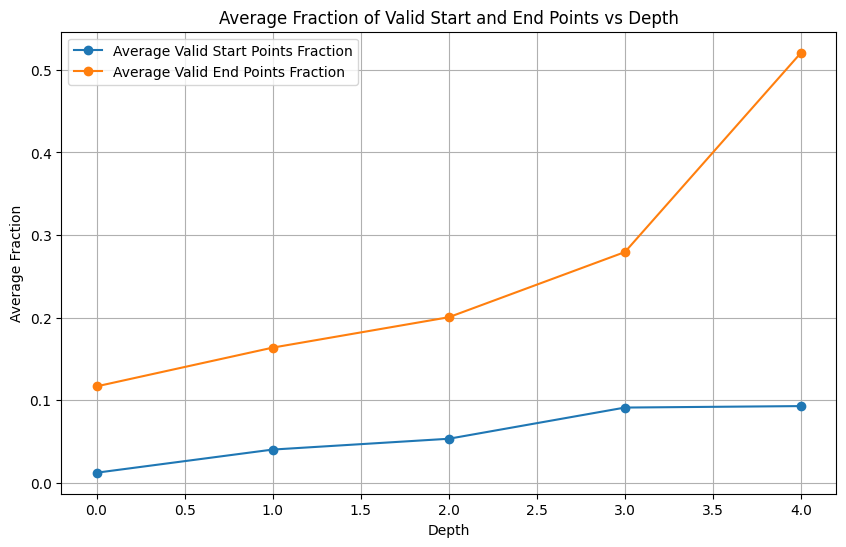

In [11]:
depths = range(5)
start_fractions = []
end_fractions = []

for depth in depths:
    start_fractions_at_depth = []
    end_fractions_at_depth = []
    for trip in trips:
        print(trip)
        valid_start_points, valid_end_points, fraction_start, fraction_end = get_valid_area_fast(street_graph, trip, max_depth=depth)
        start_fractions_at_depth.append(fraction_start)
        end_fractions_at_depth.append(fraction_end)
    start_fractions.append(sum(start_fractions_at_depth) / len(start_fractions_at_depth))
    end_fractions.append(sum(end_fractions_at_depth) / len(end_fractions_at_depth))

print(start_fractions)
print(end_fractions)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(depths, start_fractions, label="Average Valid Start Points Fraction", marker='o')
plt.plot(depths, end_fractions, label="Average Valid End Points Fraction", marker='o')
plt.xlabel("Depth")
plt.ylabel("Average Fraction")
plt.title("Average Fraction of Valid Start and End Points vs Depth")
plt.legend()
plt.grid(True)
plt.show()